## Japanese traditional painting portrait classification

### Project Background

Picture books hold a significant position in ancient and modern Japanese art. The characters' images, attire, and expressions in these books reflect the social conditions, class distribution, and political environment of their time. Among the many attributes in paintings, the facial expressions of characters are crucial for understanding the historical significance. The rich information contained within includes not only character attributes but also reflects the historical progression of the creative period. Scientists cropped facial regions from picture book images, and historical scholars provided accurate metadata (such as gender and social class) through professional annotation.

![](https://ai-studio-static-online.cdn.bcebos.com/8e4337fa80dc4dc0bb3ea3ed02f9ca85e91b7765aa9e4f4b94d0105da1af0d10)


### Project Description

To train a CNN for gender and identity classification:

### Dataset Introduction

The Kaokore dataset is used in this project, which includes two categories for gender classification and four categories for social status classification of historical Japanese characters.

## 1 Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import os
import csv
import numpy as np
import pandas as pd
from PIL import Image
import sys
import re
from itertools import islice
from sklearn.utils import shuffle

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


## 2 Data preprocessing

### 2.1 Unzip file

In [ ]:
#unzip files to current data path
!unzip -oq /home/aistudio/data/data161412/dataset.zip -d data/

### 2.2 Check image info

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


(256, 256, 3)

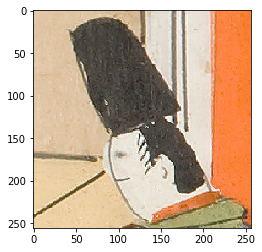

In [ ]:
#show images and print out image shape 256*256*3
img = Image.open('data/dataset/kaokore/images_256/00000002.jpg')
plt.imshow(img)
img = np.array(img)
img.shape

### 2.3 Process the original data and identify categories with sufficient sample sizes for training. 

In [ ]:
path='data/dataset/original_tags.txt'

# read txt files and select useful info
# , which is image info, gender and identity

ori_data=[]
row_list=[]
with open(path,'r') as f:
    for lines in f:
        lines = lines.strip('\n').split(',')
        # transfer image to lists
        ori_data.append(list(re.split('[:;]', lines[0])))
    # print(ori_data)        
    for lines in ori_data:
        col_list=[]
        for columns in lines:
            if columns.startswith('0'):
                col_list.append(columns)
            elif columns.startswith('性別'):
                col_list.append(columns[3:])
            elif columns.startswith('身分'):
                col_list.append(columns[3:])
        row_list.append(col_list)

# print(col_list)

In [ ]:
# transfer list to dataframe
data_df = pd.DataFrame(row_list)

# rename the dataframe
data_df.rename(columns={0:'image', 1:'gender', 2:'identity'},inplace=True)

In [ ]:
# observe data
list(data_df.groupby(['gender','identity']))

[(('不明', '不明'),
               image gender identity
  2051  00002224.jpg     不明       不明
  2052  00002225.jpg     不明       不明
  2053  00002226.jpg     不明       不明
  2058  00002231.jpg     不明       不明
  2158  00002331.jpg     不明       不明
  5353  00005625.jpg     不明       不明
  5354  00005626.jpg     不明       不明),
 (('不明', '動物'),
               image gender identity
  573   00000573.jpg     不明       動物
  574   00000574.jpg     不明       動物
  3211  00003384.jpg     不明       動物
  3212  00003385.jpg     不明       動物
  3221  00003394.jpg     不明       動物
  3222  00003395.jpg     不明       動物
  3246  00003419.jpg     不明       動物
  3247  00003420.jpg     不明       動物),
 (('不明', '庶民'),
               image gender identity
  994   00000994.jpg     不明       庶民
  2186  00002359.jpg     不明       庶民
  5380  00005652.jpg     不明       庶民
  5387  00005659.jpg     不明       庶民
  5390  00005662.jpg     不明       庶民),
 (('女', '不明'),
               image gender identity
  2054  00002227.jpg      女       不明
  2055

In [ ]:
# delete unknown gender
indexNames=data_df[data_df['gender']=='不明'].index
data_df.drop(indexNames,inplace=True)

# find out top 4 indetity classes
list1 = data_df['identity'].values.tolist()
dict(zip(*np.unique(list1, return_counts=True)))

{'不明': 8,
 '僧侶': 211,
 '動物': 9,
 '化身': 535,
 '庶民': 589,
 '武士': 1619,
 '神職': 6,
 '貴族': 2555}

In [ ]:
# Drop less frequent status categories (Unknown, Monk, Animal, Priest)
indexNames = data_df[~data_df['identity'].isin(['不明', '僧侶', '動物', '神職'])]
data_df.drop(indexNames,inplace=True)

### 2.4 构建数据标签

In [ ]:
# Map gender labels: Male=0, Female=1
# Map status labels: Noble=0, Warrior=1, Commoner=2, Bodhisattva=3

label2id_1 = {}
label_list_1 = ['男', '女']
for i, label in enumerate(label_list_1):
    label2id_1[label] = i
print(label2id_1)

label2id_2 = {}
label_list_2 = ['貴族', '武士', '庶民', '化身']
for i, label in enumerate(label_list_2):
    label2id_2[label] = i
print(label2id_2)

{'男': 0, '女': 1}
{'貴族': 0, '武士': 1, '庶民': 2, '化身': 3}


In [ ]:
# Convert labels to numeric: encode gender and identity as integers

data_df['gender'] = data_df['gender'].replace(label2id_1)
data_df['identity'] = data_df['identity'].replace(label2id_2)

In [ ]:
data_df

,image,gender,identity
0,00000000.jpg,0,0
1,00000001.jpg,0,0
2,00000002.jpg,0,0
3,00000003.jpg,0,0
4,00000004.jpg,1,0
...,...,...,...
5547,00005819.jpg,1,2
5548,00005820.jpg,0,2
5549,00005821.jpg,1,2
5550,00005822.jpg,0,2


### 2.5 Export processed data with numeric labels

In [ ]:
data_df.to_csv('img_label.csv',index=False)

### 2.6 Shuffle data and labels

In [ ]:
# Calculate total number of valid images
lenth = len(open('img_label.csv',"r").readlines())

dirpath = 'data/dataset/kaokore/images_256'
all_list=[]

# store images to list
with open('img_label.csv', encoding='utf-8-sig') as read_file:
    reader = csv.reader(read_file)
    for pic,gender,identity in islice(reader, 1, None):
        img_path = os.path.join(dirpath,pic)
        all_list.append(img_path+" "+ gender +" "+ identity +" "+"\n")

# shuffle data
all_list = shuffle(all_list)
all_str = ''.join(all_list)
f = open('data.txt','w',encoding='utf-8')
f.write(all_str)

264900

### 2.7 Data division

In [ ]:
# divide with 8:1:1 into train_data, val_data 和test_data
train_size = int(lenth * 0.8)
test_size = int(lenth * 0.1)

print(train_size)
print(test_size)

4239
529


In [ ]:
train_list = all_list[:train_size]
val_list = all_list[train_size:(train_size+test_size)]
test_list = all_list[(train_size+test_size):]

print(len(train_list))
print(len(val_list))
print(len(test_list))

4239
529
530


### 2.8 Data storage

In [ ]:
train_txt = shuffle(train_list)
train_txt = ' '.join(train_list)

f = open('train_txt.txt','w',encoding='utf-8')
f.write(train_txt)
f.close

val_txt = shuffle(val_list)
val_txt = ' '.join(val_list)

f = open('val_txt.txt','w',encoding='utf-8')
f.write(val_txt)
f.close

test_txt = shuffle(test_list)
test_txt = ' '.join(test_list)

f = open('test_txt.txt','w',encoding='utf-8')
f.write(test_txt)
f.close

<function TextIOWrapper.close()>

In [ ]:
train_img = []
train_gender_label = []
train_identity_label = []
for img_label in train_list:
    img, gender, identity, _ = img_label.split('\n')[0].split(' ')
    train_img.append(img)
    train_gender_label.append(gender)
    train_identity_label.append(identity)

val_img = []
val_gender_label = []
val_identity_label = []
for img_label in val_list:
    img, gender, identity, _ = img_label.split('\n')[0].split(' ')
    val_img.append(img)
    val_gender_label.append(gender)
    val_identity_label.append(identity)

test_img = []
test_gender_label = []
test_identity_label = []
for img_label in test_list:
    img, gender, identity, _ = img_label.split('\n')[0].split(' ')
    test_img.append(img)
    test_gender_label.append(gender)
    test_identity_label.append(identity)

In [ ]:
print(train_img[0])
print(train_gender_label[0])
print(train_identity_label[0])
print(val_img[0])
print(val_gender_label[0])
print(val_identity_label[0])
print(test_img[0])
print(test_gender_label[0])
print(test_identity_label[0])

data/dataset/kaokore/images_256/00002614.jpg
1
0
data/dataset/kaokore/images_256/00004957.jpg
0
2
data/dataset/kaokore/images_256/00003180.jpg
0
1


## 3 Constructing a dataset processing class

In [ ]:
# Constructing a dataset processing class
from paddle.io import Dataset

# gender dataset
class GenderDataset(Dataset):
    def __init__(self,mode=None):
        self.train_data, self.train_gender_label = train_img, train_gender_label
        self.val_data, self.val_gender_label = val_img, val_gender_label
        self.test_data, self.test_gender_label= test_img, test_gender_label
        if mode =='train':
            self.num_samples = len(train_img)
        elif mode =='val':
            self.num_samples = len(val_img)
        else:
            self.num_samples = len(test_img)

        self.mode = mode
    
    def __getitem__(self,idx):
        if self.mode == 'train':
            img = self.train_data[idx]
            gender_label = self.train_gender_label[idx]

        elif self.mode == 'val':
            img = self.val_data[idx]
            gender_label = self.val_gender_label[idx]

        else:
            img = self.test_data[idx]
            gender_label = self.test_gender_label[idx]


        img = Image.open(img)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = img.resize((64,64), Image.BILINEAR) # transfer to desired image size
        img = np.array(img).astype('float32')
        img = img.transpose((2,0,1)) # channel be first，hwc->chw
        img = img/255 # normalization

        return img, np.array(gender_label,dtype='int64')

    def __len__(self):
        return self.num_samples

In [ ]:
# identity dataset

class IdentityDataset(Dataset):
    def __init__(self,mode=None):
        self.train_data, self.train_identity_label = train_img, train_identity_label
        self.val_data, self.val_identity_label = val_img, val_identity_label
        self.test_data, self.test_identity_label = test_img, test_identity_label
        if mode =='train':
            self.num_samples = len(train_img)
        elif mode =='val':
            self.num_samples = len(val_img)
        else:
            self.num_samples = len(test_img)

        self.mode = mode
    
    def __getitem__(self,idx):
        if self.mode == 'train':
            img = self.train_data[idx]

            identity_label = self.train_identity_label[idx]
        elif self.mode == 'val':
            img = self.val_data[idx]

            identity_label = self.val_identity_label[idx]
        else:
            img = self.test_data[idx]

            identity_label = self.test_identity_label[idx]

        img = Image.open(img)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = img.resize((64,64), Image.BILINEAR) # transfer to desired image size
        img = np.array(img).astype('float32')
        img = img.transpose((2,0,1)) # channel be first，hwc->chw
        img = img/255 # normalization

        return img, np.array(identity_label,dtype='int64')

    def __len__(self):
        return self.num_samples

In [ ]:
# divide into train, test and validation set
train_gender_dataset = GenderDataset('train')
val_gender_dataset = GenderDataset('val')
test_gender_dataset = GenderDataset('test')

train_identity_dataset = IdentityDataset('train')
val_identity_dataset = IdentityDataset('val')
test_identity_dataset = IdentityDataset('test')

## 4 Gender model

### 4.1 Neural network model building

In [ ]:
import paddle
import paddle.nn.functional as F

class MyNet1(paddle.nn.Layer):
    def __init__(self):
        super(MyNet1, self).__init__()
        self.conv1 = paddle.nn.Conv2D(
            in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=2)
        self.max_pool1 = paddle.nn.MaxPool2D(kernel_size=2,  stride=2)
        self.conv2 = paddle.nn.Conv2D(
            in_channels=64, out_channels=128, kernel_size=3, stride=1)
        self.max_pool2 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)
        self.linear1 = paddle.nn.Linear(in_features=15*15*128, out_features=128)
        self.linear2 = paddle.nn.Linear(in_features=128, out_features=64)
        self.linear3 = paddle.nn.Linear(in_features=64, out_features=2) # 输出是2个类别
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        x = paddle.flatten(x, start_axis=1, stop_axis=-1)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return x

In [ ]:
model = MyNet1()# Model instance
paddle.summary(model,(1, 3, 64, 64))# Check Model architecture

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-7       [[1, 3, 64, 64]]     [1, 64, 66, 66]         1,792     
  MaxPool2D-7    [[1, 64, 66, 66]]     [1, 64, 33, 33]           0       
   Conv2D-8      [[1, 64, 33, 33]]     [1, 128, 31, 31]       73,856     
  MaxPool2D-8    [[1, 128, 31, 31]]    [1, 128, 15, 15]          0       
   Linear-10        [[1, 28800]]           [1, 128]          3,686,528   
   Linear-11         [[1, 128]]            [1, 64]             8,256     
   Linear-12         [[1, 64]]              [1, 2]              130      
Total params: 3,770,562
Trainable params: 3,770,562
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 3.82
Params size (MB): 14.38
Estimated Total Size (MB): 18.25
---------------------------------------------------------------

{'total_params': 3770562, 'trainable_params': 3770562}

### 4.2 Model Training

In [ ]:
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F
from PIL import Image

EPOCH_NUM = 20 # epoch number 

model.train()
opt = paddle.optimizer.SGD(learning_rate=0.000125, parameters=model.parameters())

min_loss = 1000
all_loss = []
epoch_num = []
for epoch_id in range(EPOCH_NUM):
    epoch_loss = 0
    for iter_id, data in enumerate(train_gender_dataset):
        img, gender_label= data
        img = paddle.reshape(paddle.to_tensor(img),[-1,3,64,64])
        gender_label = paddle.to_tensor(gender_label)
        gender_label = paddle.reshape(gender_label,[1])
        # forward propogation
        predicts = model(img)
        # loss func
        loss = F.cross_entropy(predicts, gender_label)
        avg_loss = paddle.mean(loss)
        epoch_loss = avg_loss

        # backword propogation
        avg_loss.backward()
        # min loss and update parameters
        opt.step()
        # clear grad
        opt.clear_grad()
    epoch_num.append(epoch_id)
    all_loss.append(epoch_loss)

    if (epoch_id % 4 ==1 ):
        print("epoch: {}, loss is: {}".format(epoch_id, avg_loss.numpy()))
        # store model params
        paddle.save(model.state_dict(), 'out/model_gender_'+str(epoch_id)+'.pdparams')

    if (epoch_loss <= min_loss):
        min_loss = epoch_loss
        # store best model params
        paddle.save(model.state_dict(), 'out/best_gender_model.pdparams')

print("train over")

epoch: 1, loss is: [1.1704009]
epoch: 5, loss is: [0.48145184]
epoch: 9, loss is: [0.31762812]
epoch: 13, loss is: [0.2452568]
epoch: 17, loss is: [0.18152168]
train over


### 4.3 Loss visualization

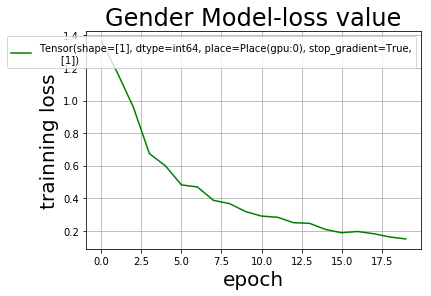

In [ ]:
def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("epoch", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=gender_label) 
    plt.legend()
    plt.grid()
    plt.show()

draw_process("Gender Model-loss value","green",epoch_num,all_loss,"trainning loss")

### 4.4 Test

In [ ]:
model1 = paddle.Model(model) 

model1.prepare(paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters()), 
              paddle.nn.CrossEntropyLoss(), 
              paddle.metric.Accuracy())


model1.fit(train_gender_dataset,  
          test_gender_dataset,   
          epochs=10,       
          batch_size=64,  
          verbose=1)      

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/10
step 67/67 [==============================] - loss: 0.1607 - acc: 0.9179 - 99ms/step         
Eval begin...
step 9/9 [==============================] - loss: 0.2055 - acc: 0.8585 - 94ms/step
Eval samples: 530
Epoch 2/10
step 67/67 [==============================] - loss: 0.1417 - acc: 0.9186 - 98ms/step         
Eval begin...
step 9/9 [==============================] - loss: 0.2333 - acc: 0.8547 - 92ms/step
Eval samples: 530
Epoch 3/10
step 67/67 [==============================] - loss: 0.1422 - acc: 0.9188 - 99ms/step         
Eval begin...
step 9/9 [==============================] - loss: 0.1976 - acc: 0.8528 - 91ms/step
Eval samples: 530
Epoch 4/10
step 67/67 [==============================] - loss: 0.2529 - acc: 0.9203 - 100ms/step        
Eval begin...
step 9/9 [==============================] - loss: 0.2672 - acc: 0.8453 - 91ms/step
Eval samples: 530
Epoch 5/10

In [ ]:
model1.evaluate(test_gender_dataset, verbose=1, batch_size=50) # 模型评估

Eval begin...
step 11/11 [==============================] - loss: 0.2288 - acc: 0.8604 - 76ms/step        
Eval samples: 530


{'loss': [0.22878689], 'acc': 0.8603773584905661}

### 4.5 Validate

In [ ]:
# real label
def real_val_label(path):
    val_gender_result = data_df.loc[(data_df['image']== path[-12:]),['gender']]
    val_gender_array = np.array(val_gender_result)
    val_gender_list =val_gender_array.tolist()

    if val_gender_list == [[1]]:
     return "女"
    else:
     return "男"

1
实际标签为: 女
预测标签为: 女
Tensor(shape=[1, 2], dtype=float32, place=Place(gpu:0), stop_gradient=False,
       [[0.48466453, 0.51533544]])


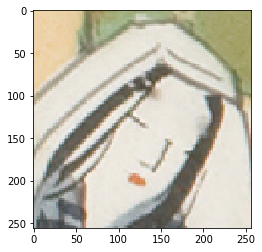

In [ ]:
model = MyNet1()

param_gender_dict = paddle.load('out/best_gender_model.pdparams')
model.load_dict(param_gender_dict)

# start validation
model.eval()
def evalImg(path):
    img = Image.open(path)
    plt.imshow(img)

    if img.mode != 'RGB': 
        img = img.convert('RGB') 
    img = img.resize((64, 64), Image.BILINEAR) 
    img = np.array(img).astype('float32') 
    img = img.transpose((2, 0, 1)) 
    img = img/255  
    img = paddle.reshape(paddle.to_tensor(img),[-1,3,64,64])

    predicts = model(img)
    p = predicts.numpy().argmax()  
    print(p)
    print("实际标签为:", real_val_label(path))
    print("预测标签为:", label_list_1[p])
    print(F.softmax(predicts))

    return real_val_label(path),label_list_1[p]

type_real,type_pre = evalImg('data/dataset/kaokore/images_256/00005176.jpg')

## 5 Indentity Model

### 5.1 Neural network model building

In [41]:
import paddle
import paddle.nn.functional as F

class MyNet2(paddle.nn.Layer):
    def __init__(self):
        super(MyNet2, self).__init__()
        self.conv1 = paddle.nn.Conv2D(
            in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=2)
        self.max_pool1 = paddle.nn.MaxPool2D(kernel_size=2,  stride=2)
        self.conv2 = paddle.nn.Conv2D(
            in_channels=64, out_channels=128, kernel_size=3, stride=1)
        self.max_pool2 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)
        self.linear1 = paddle.nn.Linear(in_features=15*15*128, out_features=128)
        self.linear2 = paddle.nn.Linear(in_features=128, out_features=64)
        self.linear3 = paddle.nn.Linear(in_features=64, out_features=4) # 输出是4个类别
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        x = paddle.flatten(x, start_axis=1, stop_axis=-1)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return x

In [ ]:
model = MyNet2()
paddle.summary(model,(1, 3, 64, 64))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-17      [[1, 3, 64, 64]]     [1, 64, 66, 66]         1,792     
 MaxPool2D-17    [[1, 64, 66, 66]]     [1, 64, 33, 33]           0       
   Conv2D-18     [[1, 64, 33, 33]]     [1, 128, 31, 31]       73,856     
 MaxPool2D-18    [[1, 128, 31, 31]]    [1, 128, 15, 15]          0       
   Linear-25        [[1, 28800]]           [1, 128]          3,686,528   
   Linear-26         [[1, 128]]            [1, 64]             8,256     
   Linear-27         [[1, 64]]              [1, 4]              260      
Total params: 3,770,692
Trainable params: 3,770,692
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 3.82
Params size (MB): 14.38
Estimated Total Size (MB): 18.25
---------------------------------------------------------------

{'total_params': 3770692, 'trainable_params': 3770692}

### 5.2 Model training

In [ ]:
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F
from PIL import Image

EPOCH_NUM = 20 

model.train()

opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())

min_loss = 1000
all_loss = []
epoch_num = []
for epoch_id in range(EPOCH_NUM):

    epoch_loss = 0
    for iter_id, data in enumerate(train_identity_dataset):
        img, identity_label= data
        img = paddle.reshape(paddle.to_tensor(img),[-1,3,64,64])
        identity_label = paddle.to_tensor(identity_label)
        identity_label = paddle.reshape(identity_label,[1])

        predicts = model(img)

        loss = F.cross_entropy(predicts, identity_label)
        avg_loss = paddle.mean(loss)
        epoch_loss = avg_loss

        avg_loss.backward()

        opt.step()
        
        opt.clear_grad()
    epoch_num.append(epoch_id)
    all_loss.append(epoch_loss)
    if (epoch_id % 4 ==1 ):
        print("epoch: {}, loss is: {}".format(epoch_id, avg_loss.numpy()))
        paddle.save(model.state_dict(), 'out/model_identity_'+str(epoch_id)+'.pdparams')
    if (epoch_loss <= min_loss):
        min_loss = epoch_loss
        paddle.save(model.state_dict(), 'out/best_identity_model.pdparams')

print("train over")

epoch: 1, loss is: [0.86037326]
epoch: 5, loss is: [0.36866194]
epoch: 9, loss is: [0.02591661]
epoch: 13, loss is: [0.00447475]
epoch: 17, loss is: [0.00556705]
train over


### 5.3 Loss visualization

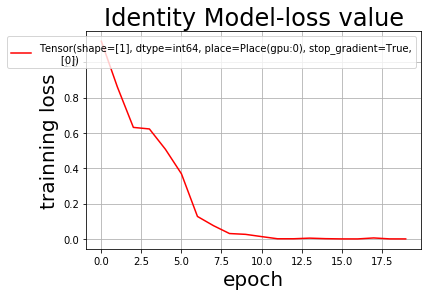

In [44]:
def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("epoch", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=identity_label) 
    plt.legend()
    plt.grid()
    plt.show()

draw_process("Identity Model-loss value","red",epoch_num,all_loss,"trainning loss")

### 5.4 测试

In [ ]:
model2 = paddle.Model(model) 

model2.prepare(paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters()), 
              paddle.nn.CrossEntropyLoss(), 
              paddle.metric.Accuracy())

model2.fit(train_identity_dataset,  
          test_identity_dataset,  
          epochs=20,       
          batch_size=64,  
          verbose=1)      

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/20
step 67/67 [==============================] - loss: 5.5598e-04 - acc: 1.0000 - 101ms/step    
Eval begin...
step 9/9 [==============================] - loss: 2.0681 - acc: 0.6943 - 92ms/step
Eval samples: 530
Epoch 2/20
step 67/67 [==============================] - loss: 0.0075 - acc: 1.0000 - 99ms/step         
Eval begin...
step 9/9 [==============================] - loss: 2.0656 - acc: 0.6943 - 93ms/step
Eval samples: 530
Epoch 3/20
step 67/67 [==============================] - loss: 0.0024 - acc: 1.0000 - 100ms/step        
Eval begin...
step 9/9 [==============================] - loss: 2.0625 - acc: 0.6943 - 92ms/step
Eval samples: 530
Epoch 4/20
step 67/67 [==============================] - loss: 0.0093 - acc: 1.0000 - 100ms/step        
Eval begin...
step 9/9 [==============================] - loss: 2.0568 - acc: 0.6943 - 92ms/step
Eval samples: 530
Epoch 5/20

In [50]:
model2.evaluate(test_identity_dataset, verbose=1, batch_size=50) # 模型评估

Eval begin...
step 11/11 [==============================] - loss: 1.6455 - acc: 0.6962 - 77ms/step        
Eval samples: 530


{'loss': [1.6454599], 'acc': 0.6962264150943396}

### 5.5 Validation

In [ ]:
def real_val_label(path):
    val_identity_result = data_df.loc[(data_df['image']== path[-12:]),['identity']]
    val_identity_array = np.array(val_identity_result)
    val_identity_list =val_identity_array.tolist()

    if val_identity_list == [[0]]:
     return "貴族"
    elif val_identity_list == [[1]]:
     return "武士"
    elif val_identity_list == [[2]]:
     return "化身"
    elif val_identity_list == [[3]]:
     return "庶民"

2
实际标签为: 庶民
预测标签为: 庶民
Tensor(shape=[1, 4], dtype=float32, place=Place(gpu:0), stop_gradient=False,
       [[0.01409089, 0.00096119, 0.56133467, 0.42361319]])


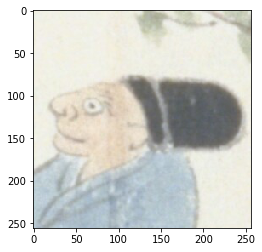

In [ ]:
model = MyNet2()

param_identity_dict = paddle.load('out/best_identity_model.pdparams')
model.load_dict(param_identity_dict)

model.eval()
def evalImg(path):
    img = Image.open(path)
    plt.imshow(img)

    if img.mode != 'RGB': 
        img = img.convert('RGB') 
    img = img.resize((64, 64), Image.BILINEAR) 
    img = np.array(img).astype('float32') 
    img = img.transpose((2, 0, 1)) 
    img = img/255  
    img = paddle.reshape(paddle.to_tensor(img),[-1,3,64,64])


    predicts = model(img)
    p = predicts.numpy().argmax()  
    print(p)
    print("实际标签为:", real_val_label(path))
    print("预测标签为:", label_list_2[p])
    print(F.softmax(predicts))

    return real_val_label(path),label_list_2[p]

type_real,type_pre = evalImg('data/dataset/kaokore/images_256/00004977.jpg')

## Project summary

### Previous experience with labeled datasets:

1. First time working with raw labels in the Kaokore dataset taught me how to extract useful information from txt files, unlike using pre-processed data in previous classification tasks.

2. Dataset observation is crucial. Using DataFrame's groupby method helps categorize data. When processing raw labels, carefully observe and remove categories with insufficient data that cannot support training.

3. The Kaokore dataset uses Japanese and Chinese annotations. Some characters appear Chinese but are actually input using Japanese methods. When using text labels, copy-paste to avoid input method issues.

### Project Implementation:
1. Successfully completed model training, testing, and validation using custom network architecture.

2. Model architecture improvements: Increase network depth, Add residual structures

3. Hyperparameter tuning: Learning rate adjustments, Batch size optimization

4. Training methodology: Optimizer selection, Epoch configuration